In [1]:
from copy import deepcopy
import os
import sys
from datetime import datetime

In [2]:
import matplotlib.pyplot as plt
from numba import njit
import numpy as np
import pandas as pd

from scipy.optimize import basinhopping, minimize
from scipy.stats import chisquare

sys.path.append(os.path.dirname(sys.path[0]))

In [4]:
from rmo import RadialMovementOptimization
import scripts.constants as con
from scripts.helpers import get_unique_frame
from scripts.plotter import Plotter, get_temperature_legend
from scripts.properties.ovito_procedures import OvitoProcessor

from scripts.rdf_calculator import RDFCalculator

In [5]:
np.random.seed(0)

In [6]:
@njit
def math_round(value):
    rest = value - int(value)
    if rest >= 0.5 and value >= 0:
        return float(int(value) + 1)
    if rest <= -0.5 and value < 0:
        return float(int(value) - 1)
    return float(int(value))

@njit
def get_boundary_conditions(
        cell_dimensions: np.ndarray,
        particles_number: int,
        positions: np.ndarray,
):
    for i in range(particles_number):
        for j in range(3):
            if positions[i][j] >= cell_dimensions[j] / 2.0:
                positions[i][j] -= (
                        math_round(positions[i][j] / cell_dimensions[j])
                        * cell_dimensions[j]
                )
            if positions[i][j] < -cell_dimensions[j] / 2.0:
                positions[i][j] -= (
                        math_round(positions[i][j] / cell_dimensions[j])
                        * cell_dimensions[j]
                )
    return positions

In [7]:
def calculate_rdf(positions):
    cell_dimensions = np.array([12.25, 12.25, 12.25])
    radii, rdf = OvitoProcessor(
        positions=positions, 
        cell_dimensions=cell_dimensions,
    ).get_rdf()
    return radii, rdf

In [8]:
def mse(obs, exp):
    return np.sum((obs - exp) ** 2)

In [9]:
def generate_random_state() -> None:
    particles_number = 1372
    cell_dimensions = 12.25 * np.ones(3)
    return (np.random.random((particles_number, 3)) - 0.5) * cell_dimensions

In [10]:
CURRENT_DATA_NORMAL = '2021-09-24_prepared_1.3_normal'
PLOT_FILENAME_POSTFIX_NORMAL = 'rmo'

PATH_TO_CURRENT_DATA_NORMAL = os.path.join(con.PATH_TO_DATA, CURRENT_DATA_NORMAL)
PATH_TO_PLOTS = os.path.join(con.PATH_TO_PLOTS, CURRENT_DATA_NORMAL)

PATH_TO_CURRENT_DATA_NORMAL

'C:\\albert\\git_reps\\molecular_dynamics\\data\\2021-09-24_prepared_1.3_normal'

In [11]:
samples = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'samples.npy'))
test_sample = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'test_sample.npy'))
targets = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'targets_pbc.npy'))
cooled_1 = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'cooled_1.npy'))
cooled_2 = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'cooled_2.npy'))

samples.shape, test_sample.shape, targets.shape, cooled_1.shape, cooled_2.shape

((2464, 612), (1, 612), (2464, 1372, 3), (1372, 3), (1372, 3))

In [12]:
i = 1

obs_rdf = calculate_rdf(targets[i])[1]

is_break = False
while not is_break:
    some_positions = generate_random_state()
    _mse = mse(obs=obs_rdf, exp=calculate_rdf(np.array(some_positions))[1])
    is_break = _mse < 130
    
    
some_positions.shape

(1372, 3)

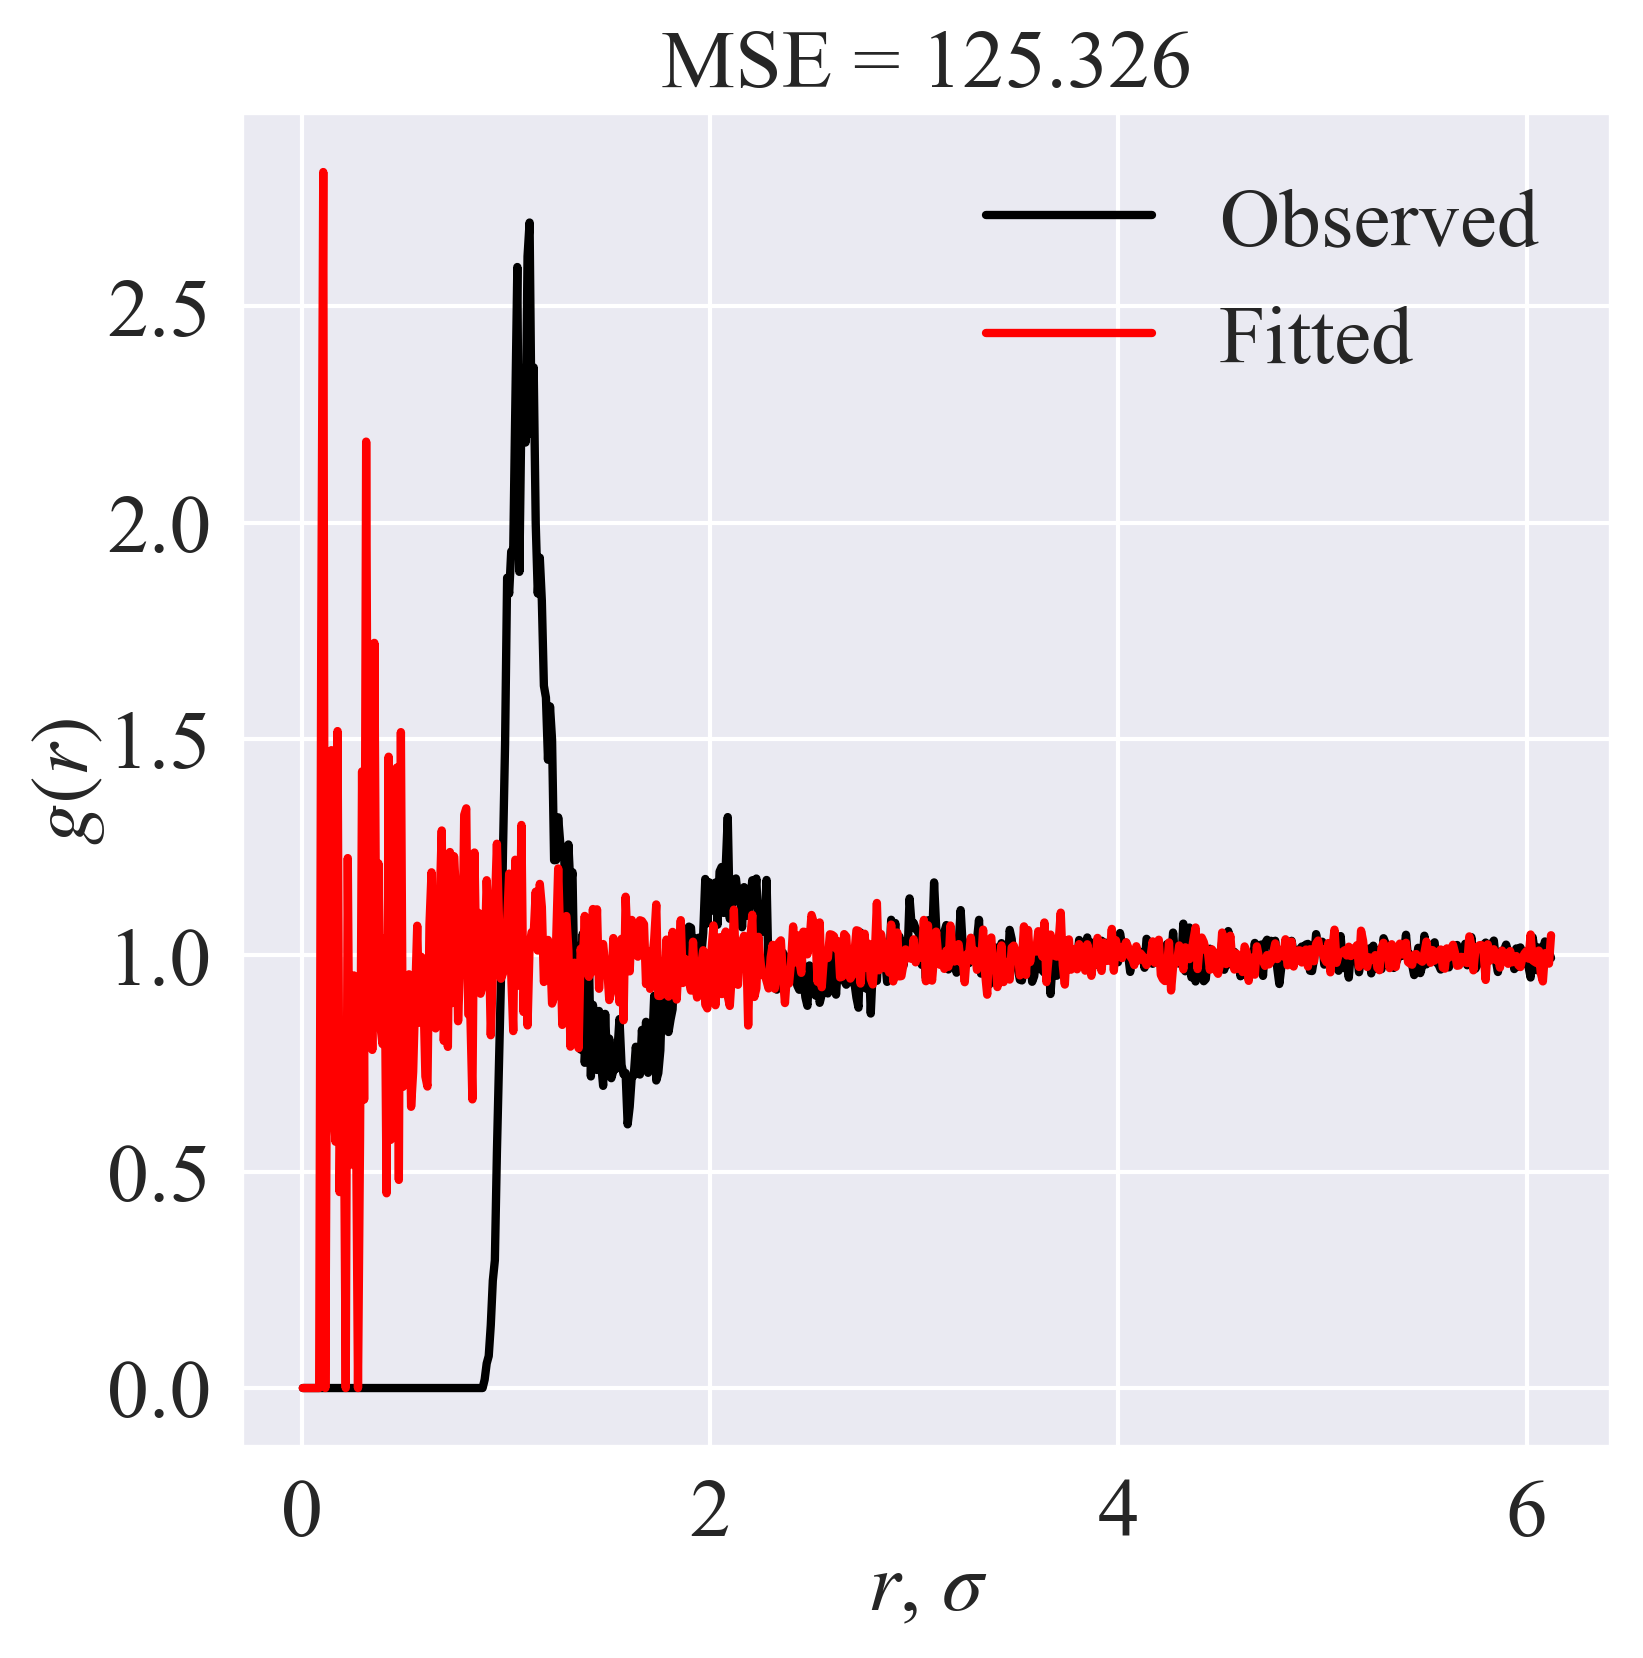

In [13]:
radii, exp_rdf = calculate_rdf(np.array(some_positions))
size = obs_rdf.size
radii = radii[:size]
exp_rdf = exp_rdf[:size]

plotter = Plotter(
    path_to_plots=PATH_TO_PLOTS,
    labels=('radius', 'rdf'),
)
plotter.ax.plot(radii, obs_rdf, color='black', label='Observed')
plotter.ax.plot(radii, exp_rdf, color='red', label='Fitted')
plotter.set_title(f'MSE = {mse(obs=obs_rdf, exp=exp_rdf):.3f}')
plotter.get_legend()
plotter.save_plot('initial_state_local.png')
plt.show()

In [14]:
cell_dimensions = np.ones(3) * 12.25

In [15]:
def optimized_func(positions):
    collided_number = 0
    positions = positions.reshape(1372, 3)
    radii, exp_rdf = calculate_rdf(positions)
    size = obs_rdf.size
    radii = radii[:size]
    exp_rdf = exp_rdf[:size]
    if np.where(exp_rdf > 0)[0][0] < np.where(obs_rdf > 0)[0][0]:
        collided_number = exp_rdf[np.where(exp_rdf > 0)[0]].sum()
    result = mse(obs=obs_rdf, exp=exp_rdf)
    return result, collided_number

In [16]:
def interruption_proof_rmo(args, function, generations_number, particles_number, c_parameters, scale, weight_limits):
    outer_start = datetime.now()
    flattened = np.array(args).flatten()
    rmo_instance = RadialMovementOptimization(
        generations_number=generations_number,
        particles_number=particles_number,
        dimensions_number=flattened.size,
        bounds=(-cell_dimensions[0] / 2, cell_dimensions[0] / 2),
        centre=flattened,
    )
    try:
        rmo_instance.optimize(
            func=function,
            c_parameters=c_parameters,
            scale=scale,
            weight_limits=weight_limits,
        )
    except (KeyboardInterrupt, SystemError):
        pass
    print(f'{datetime.now() - outer_start = }')
    return rmo_instance.global_best.reshape(args.shape)

In [22]:
new_positions = interruption_proof_rmo(
    args=some_positions,
    function=lambda x: optimized_func(x)[1],
    generations_number=10,
    particles_number=100,
    c_parameters=(0.9, 1.1),
    scale=10,
    weight_limits=(0, 1)
)

global_minimum = 599.74914
gen = 0; gen_min = 599.7491; global = 599.7491; denominator = 10; execution_time = 0:00:03.899589
gen = 1; gen_min = 599.7491; global = 599.7491; denominator = 10; execution_time = 0:00:03.809758
gen = 2; gen_min = 596.3605; global = 596.3605; denominator = 10; execution_time = 0:00:05.151590
gen = 3; gen_min = 597.6324; global = 596.3605; denominator = 10; execution_time = 0:00:05.162427
gen = 4; gen_min = 595.8056; global = 595.8056; denominator = 10; execution_time = 0:00:05.207755
gen = 5; gen_min = 594.0517; global = 594.0517; denominator = 10; execution_time = 0:00:05.130629
gen = 6; gen_min = 595.1225; global = 594.0517; denominator = 10; execution_time = 0:00:04.850240
gen = 7; gen_min = 600.5587; global = 594.0517; denominator = 10; execution_time = 0:00:04.867395
gen = 8; gen_min = 600.4013; global = 594.0517; denominator = 10; execution_time = 0:00:04.891524
gen = 9; gen_min = 609.2721; global = 594.0517; denominator = 10; execution_time = 0:00:05.

In [18]:
scale = 10
out = optimized_func(new_positions)[1]

for i in range(20):
    print(f'{i = }')
    new_positions = interruption_proof_rmo(
        args=new_positions,
        function=lambda x: optimized_func(x)[1],
        generations_number=5,
        particles_number=100,
        c_parameters=(1.9, 2.0),
        scale=scale,
        weight_limits=(0, 1)
    )
    new_out = optimized_func(new_positions)[1]
    out = new_out

i = 0
global_minimum = 590.14943
gen = 0; gen_min = 590.1494; global = 590.1494; denominator = 10; execution_time = 0:00:03.055098
gen = 1; gen_min = 590.1494; global = 590.1494; denominator = 10; execution_time = 0:00:03.010383
gen = 2; gen_min = 590.1494; global = 590.1494; denominator = 10; execution_time = 0:00:03.045236
gen = 3; gen_min = 590.1494; global = 590.1494; denominator = 10; execution_time = 0:00:03.298228
gen = 4; gen_min = 590.1494; global = 590.1494; denominator = 10; execution_time = 0:00:02.972540
datetime.now() - outer_start = datetime.timedelta(seconds=15, microseconds=416734)
i = 1
global_minimum = 590.14943
gen = 0; gen_min = 590.1494; global = 590.1494; denominator = 10; execution_time = 0:00:03.012415
gen = 1; gen_min = 590.1494; global = 590.1494; denominator = 10; execution_time = 0:00:02.998937
gen = 2; gen_min = 590.1494; global = 590.1494; denominator = 10; execution_time = 0:00:02.994929
gen = 3; gen_min = 590.1494; global = 590.1494; denominator = 10; e

gen = 3; gen_min = 586.4065; global = 586.4065; denominator = 10; execution_time = 0:00:02.917226
gen = 4; gen_min = 584.3289; global = 584.3289; denominator = 10; execution_time = 0:00:02.928011
datetime.now() - outer_start = datetime.timedelta(seconds=14, microseconds=484459)
i = 14
global_minimum = 584.32888
gen = 0; gen_min = 584.3289; global = 584.3289; denominator = 10; execution_time = 0:00:03.196291
gen = 1; gen_min = 584.3289; global = 584.3289; denominator = 10; execution_time = 0:00:03.323854
gen = 2; gen_min = 584.3289; global = 584.3289; denominator = 10; execution_time = 0:00:03.093595
gen = 3; gen_min = 584.3289; global = 584.3289; denominator = 10; execution_time = 0:00:02.978970
gen = 4; gen_min = 584.3289; global = 584.3289; denominator = 10; execution_time = 0:00:02.966313
datetime.now() - outer_start = datetime.timedelta(seconds=15, microseconds=594490)
i = 15
global_minimum = 584.32888
gen = 0; gen_min = 584.3289; global = 584.3289; denominator = 10; execution_time

In [19]:
scale = 20
out = optimized_func(new_positions)[1]

for i in range(20):
    print(f'{i = }')
    new_positions = interruption_proof_rmo(
        args=new_positions,
        function=lambda x: optimized_func(x)[1],
        generations_number=5,
        particles_number=100,
        c_parameters=(0.9, 1.0),
        scale=scale,
        weight_limits=(0, 1)
    )
    new_out = optimized_func(new_positions)[1]
#     if new_out == out:
#         scale *= 2
    out = new_out

i = 0
global_minimum = 584.32888
gen = 0; gen_min = 584.3289; global = 584.3289; denominator = 20; execution_time = 0:00:02.881132
gen = 1; gen_min = 584.3289; global = 584.3289; denominator = 20; execution_time = 0:00:02.855514
gen = 2; gen_min = 584.3289; global = 584.3289; denominator = 20; execution_time = 0:00:02.887290
gen = 3; gen_min = 584.3289; global = 584.3289; denominator = 20; execution_time = 0:00:02.905022
gen = 4; gen_min = 584.3289; global = 584.3289; denominator = 20; execution_time = 0:00:02.906168
datetime.now() - outer_start = datetime.timedelta(seconds=14, microseconds=467691)
i = 1
global_minimum = 584.32888
gen = 0; gen_min = 584.3289; global = 584.3289; denominator = 20; execution_time = 0:00:02.975454
gen = 1; gen_min = 584.3289; global = 584.3289; denominator = 20; execution_time = 0:00:02.964847
gen = 2; gen_min = 584.3289; global = 584.3289; denominator = 20; execution_time = 0:00:03.025129
gen = 3; gen_min = 584.3289; global = 584.3289; denominator = 20; e

gen = 3; gen_min = 579.6213; global = 579.6213; denominator = 20; execution_time = 0:00:03.502381
gen = 4; gen_min = 579.6213; global = 579.6213; denominator = 20; execution_time = 0:00:03.384818
datetime.now() - outer_start = datetime.timedelta(seconds=18, microseconds=54010)
i = 14
global_minimum = 579.62135
gen = 0; gen_min = 579.6213; global = 579.6213; denominator = 20; execution_time = 0:00:03.666911
gen = 1; gen_min = 579.6213; global = 579.6213; denominator = 20; execution_time = 0:00:03.256522
gen = 2; gen_min = 579.6213; global = 579.6213; denominator = 20; execution_time = 0:00:03.223667
gen = 3; gen_min = 579.6213; global = 579.6213; denominator = 20; execution_time = 0:00:03.096430
gen = 4; gen_min = 579.6213; global = 579.6213; denominator = 20; execution_time = 0:00:03.583617
datetime.now() - outer_start = datetime.timedelta(seconds=16, microseconds=868548)
i = 15
global_minimum = 579.62135
gen = 0; gen_min = 579.6213; global = 579.6213; denominator = 20; execution_time 

In [37]:
scale = 3000
out = optimized_func(new_positions)[1]

for i in range(20):
    print(f'{i = }')
    new_positions = interruption_proof_rmo(
        args=new_positions,
        function=lambda x: optimized_func(x)[1],
        generations_number=5,
        particles_number=100,
        c_parameters=(0.9, 1.0),
        scale=scale,
        weight_limits=(0, 1)
    )
    new_out = optimized_func(new_positions)[1]
    if new_out == out:
        scale *= 2
    out = new_out

i = 0
global_minimum = 544.37793
gen = 0; gen_min = 544.3779; global = 544.3779; denominator = 3000; execution_time = 0:00:05.209419
gen = 1; gen_min = 544.3779; global = 544.3779; denominator = 3000; execution_time = 0:00:05.344762
gen = 2; gen_min = 544.3779; global = 544.3779; denominator = 3000; execution_time = 0:00:05.232492
gen = 3; gen_min = 544.3779; global = 544.3779; denominator = 3000; execution_time = 0:00:05.163951
gen = 4; gen_min = 544.3779; global = 544.3779; denominator = 3000; execution_time = 0:00:04.894434
datetime.now() - outer_start = datetime.timedelta(seconds=25, microseconds=899966)
i = 1
global_minimum = 544.37793
gen = 0; gen_min = 544.3779; global = 544.3779; denominator = 6000; execution_time = 0:00:05.100382
gen = 1; gen_min = 544.3779; global = 544.3779; denominator = 6000; execution_time = 0:00:05.010608
gen = 2; gen_min = 544.3779; global = 544.3779; denominator = 6000; execution_time = 0:00:04.991335
gen = 3; gen_min = 544.3779; global = 544.3779; den

gen = 1; gen_min = 544.3779; global = 544.3779; denominator = 6144000; execution_time = 0:00:05.271941
gen = 2; gen_min = 544.3779; global = 544.3779; denominator = 6144000; execution_time = 0:00:05.001598
gen = 3; gen_min = 544.3779; global = 544.3779; denominator = 6144000; execution_time = 0:00:05.159997
gen = 4; gen_min = 544.3779; global = 544.3779; denominator = 6144000; execution_time = 0:00:05.034106
datetime.now() - outer_start = datetime.timedelta(seconds=25, microseconds=412788)
i = 14
global_minimum = 544.37790
gen = 0; gen_min = 544.3779; global = 544.3779; denominator = 6144000; execution_time = 0:00:05.086631
gen = 1; gen_min = 544.3779; global = 544.3779; denominator = 6144000; execution_time = 0:00:05.058510
gen = 2; gen_min = 544.3779; global = 544.3779; denominator = 6144000; execution_time = 0:00:05.117019
gen = 3; gen_min = 544.3779; global = 544.3779; denominator = 6144000; execution_time = 0:00:04.830423
gen = 4; gen_min = 544.3779; global = 544.3779; denominator

In [38]:
new_positions.shape

(1372, 3)

In [40]:
radii, new_exp_rdf = calculate_rdf(new_positions)
size = obs_rdf.size
radii = radii[:size]
new_exp_rdf = new_exp_rdf[:size]

In [41]:
def hooke_jeeves_minimization(
        optimized,
        function: callable,
        accuracy,
        step: float,
        minimized_index: int
):
    old_result = function(optimized)
    new_result = np.array(old_result)
    mse_values = [old_result[0]]
    parameters_array = [np.array(optimized)]
    outer_step_number = 1
    while step > accuracy:
        inner_start = datetime.now()
        print(f'{outer_step_number = }')
        print(f'{step = }')
        x_old = np.array(optimized)
        for i in range(optimized.shape[0]):
            if i % 100 == 0:
                print(f'{i}/{optimized.shape[0]} particles are processed at step {outer_step_number}...')
                
            for j in range(optimized.shape[1]):
                _steps = np.zeros(optimized.shape)
                _steps[i][j] += step
                new_result = function(optimized + _steps)
                
                if minimized_index == -1:
                    if (new_result[0] < old_result[0]) and (new_result[1] < old_result[1]):
                        optimized += _steps
                        old_result = np.array(new_result)
                    else:
                        new_result = function(optimized - _steps)
                        if (new_result[0] < old_result[0]) and (new_result[1] < old_result[1]):
                            optimized -= _steps
                            old_result = np.array(new_result)
                        else:
                            new_result = np.array(old_result)
                else:
                    if (new_result[minimized_index] < old_result[minimized_index]):
                        optimized += _steps
                        old_result = np.array(new_result)
                    else:
                        new_result = function(optimized - _steps)
                        if (new_result[minimized_index] < old_result[minimized_index]):
                            optimized -= _steps
                            old_result = np.array(new_result)
                        else:
                            new_result = np.array(old_result)
                print(new_result)
            
        x_new = np.array(optimized)
        optimized = x_old + 2 * (x_new - x_old)
        old_result = function(optimized)
        if old_result[0] >= new_result[0]:
            optimized = np.array(x_new)
            old_result = np.array(new_result)
            step = step / 5
        outer_step_number += 1
        mse_values.append(old_result[0])
        parameters_array.append(np.array(optimized))
        print(f'Current MSE = {old_result[0]}')
        if len(mse_values) > 2 and mse_values[-1] == mse_values[-2]:
            break
        print(f'{datetime.now() - inner_start = }')
    return optimized, mse_values, parameters_array

In [42]:
def interruption_proof_hj(minimization_method, args, **kwargs):
    outer_start = datetime.now()
    optimized = np.array(args)
    try:
        optimized, mse_values, parameters_array = minimization_method(optimized, **kwargs)
        print(mse_values)
    except (KeyboardInterrupt, SystemError):
        return optimized, [], [np.array(optimized)]
    print(f'{datetime.now() - outer_start = }')
    return optimized, mse_values, parameters_array

In [43]:
new_positions_hj, mse_values, parameters_array = interruption_proof_hj(
    minimization_method=hooke_jeeves_minimization,
    args=new_positions,
    function=optimized_func,
    accuracy=1e-9,
    step=0.001,
    minimized_index=-1,
)

outer_step_number = 1
step = 0.001
0/1372 particles are processed at step 1...
[ 50.02615284 544.37785781]
(50.02546764266389, 544.3777250454043)
[ 50.02546764 544.37772505]
[ 50.02546764 544.37772505]
(50.024227021412365, 544.3777032217967)
[ 50.02422702 544.37770322]
[ 50.02422702 544.37770322]
[ 50.02422702 544.37770322]
[ 50.02422702 544.37770322]
(50.01802886913173, 544.3775652305803)
[ 50.01802887 544.37756523]
[ 50.01802887 544.37756523]
(50.01783359945356, 544.3775061444838)
(50.017699836123725, 544.3772780502284)
[ 50.01769984 544.37727805]
[ 50.01769984 544.37727805]
[ 50.01769984 544.37727805]
[ 50.01769984 544.37727805]
(50.015750572564016, 544.3772278098952)
[ 50.01575057 544.37722781]
(50.015533461389474, 544.3772235544075)
[ 50.01553346 544.37722355]
(50.0120692039536, 544.3770393267205)
[ 50.0120692  544.37703933]
[ 50.0120692  544.37703933]
(50.01088781817967, 544.3765169362066)
[ 50.01088782 544.37651694]
[ 50.01088782 544.37651694]
[ 50.01088782 544.37651694]
[ 50.01

[ 49.83661438 544.36704332]
[ 49.83661438 544.36704332]
(49.83234266787699, 544.3665384508461)
[ 49.83234267 544.36653845]
[ 49.83234267 544.36653845]
[ 49.83234267 544.36653845]
[ 49.83234267 544.36653845]
(49.821418776725224, 544.366308108944)
[ 49.82141878 544.36630811]
[ 49.82141878 544.36630811]
[ 49.82141878 544.36630811]
[ 49.82141878 544.36630811]
[ 49.82141878 544.36630811]
(49.820610820027724, 544.3662444183317)
(49.81939680625104, 544.3661268900203)
(49.81731947620972, 544.3660057867623)
(49.81472586311663, 544.3659221306272)
[ 49.81472586 544.36592213]
[ 49.81472586 544.36592213]
[ 49.81472586 544.36592213]
(49.81249094618809, 544.3658963251876)
[ 49.81249095 544.36589633]
[ 49.81249095 544.36589633]
(49.81047062836531, 544.3657900742585)
(49.80973794295029, 544.3657352787336)
[ 49.80973794 544.36573528]
(49.808695794865955, 544.3656861001803)
[ 49.80869579 544.3656861 ]
[ 49.80869579 544.3656861 ]
[ 49.80869579 544.3656861 ]
[ 49.80869579 544.3656861 ]
(49.80855174029072, 

(49.665869590078195, 544.3575442079604)
[ 49.66586959 544.35754421]
[ 49.66586959 544.35754421]
(49.66570142389105, 544.3575370654091)
[ 49.66570142 544.35753707]
[ 49.66570142 544.35753707]
(49.66440069914401, 544.3575079685335)
[ 49.6644007  544.35750797]
(49.6630803977626, 544.3573131150835)
(49.661174424158816, 544.357288740396)
[ 49.66117442 544.35728874]
(49.65586433534043, 544.3572727406124)
[ 49.65586434 544.35727274]
[ 49.65586434 544.35727274]
(49.65446695341837, 544.3572377550803)
(49.65369951655717, 544.3570268879063)
[ 49.65369952 544.35702689]
(49.64490164536176, 544.3567635904808)
(49.644387717351954, 544.3564340771777)
[ 49.64438772 544.35643408]
[ 49.64438772 544.35643408]
[ 49.64438772 544.35643408]
[ 49.64438772 544.35643408]
[ 49.64438772 544.35643408]
[ 49.64438772 544.35643408]
(49.641616688847215, 544.356353878811)
(49.64056084019286, 544.3562551035088)
[ 49.64056084 544.3562551 ]
[ 49.64056084 544.3562551 ]
[ 49.64056084 544.3562551 ]
[ 49.64056084 544.3562551 ]

[ 49.55432413 544.34990995]
(49.55258538299955, 544.3498511230117)
[ 49.55258538 544.34985112]
[ 49.55258538 544.34985112]
[ 49.55258538 544.34985112]
[ 49.55258538 544.34985112]
[ 49.55258538 544.34985112]
[ 49.55258538 544.34985112]
[ 49.55258538 544.34985112]
[ 49.55258538 544.34985112]
[ 49.55258538 544.34985112]
(49.55081300474157, 544.3498104942004)
[ 49.550813   544.34981049]
(49.5482627270931, 544.3497030608363)
[ 49.54826273 544.34970306]
[ 49.54826273 544.34970306]
[ 49.54826273 544.34970306]
(49.54749040916521, 544.3496938871732)
[ 49.54749041 544.34969389]
[ 49.54749041 544.34969389]
[ 49.54749041 544.34969389]
[ 49.54749041 544.34969389]
[ 49.54749041 544.34969389]
(49.54591893447322, 544.3496299396152)
[ 49.54591893 544.34962994]
[ 49.54591893 544.34962994]
(49.545509784265796, 544.3495636304501)
(49.5436655480676, 544.3493537206068)
(49.541609057839146, 544.3493002139529)
[ 49.54160906 544.34930021]
[ 49.54160906 544.34930021]
(49.54020510481189, 544.3492586766383)
(49.5

[ 49.41207712 544.34161246]
[ 49.41207712 544.34161246]
(49.410021768506695, 544.3414304272815)
(49.40870506244001, 544.3413341426794)
[ 49.40870506 544.34133414]
[ 49.40870506 544.34133414]
(49.40829027459056, 544.3413302817455)
[ 49.40829027 544.34133028]
[ 49.40829027 544.34133028]
(49.4078251893287, 544.3412825677035)
[ 49.40782519 544.34128257]
[ 49.40782519 544.34128257]
[ 49.40782519 544.34128257]
[ 49.40782519 544.34128257]
(49.40776142479825, 544.3412769199238)
[ 49.40776142 544.34127692]
[ 49.40776142 544.34127692]
[ 49.40776142 544.34127692]
[ 49.40776142 544.34127692]
[ 49.40776142 544.34127692]
[ 49.40776142 544.34127692]
[ 49.40776142 544.34127692]
[ 49.40776142 544.34127692]
[ 49.40776142 544.34127692]
(49.407531919140204, 544.3412544342871)
(49.40710400346474, 544.341230604729)
[ 49.407104  544.3412306]
[ 49.407104  544.3412306]
[ 49.407104  544.3412306]
[ 49.407104  544.3412306]
[ 49.407104  544.3412306]
[ 49.407104  544.3412306]
[ 49.407104  544.3412306]
[ 49.407104  

[ 49.26613591 544.33491149]
[ 49.26613591 544.33491149]
(49.26609893565413, 544.334477839755)
(49.259008308499915, 544.3342862540837)
[ 49.25900831 544.33428625]
[ 49.25900831 544.33428625]
[ 49.25900831 544.33428625]
[ 49.25900831 544.33428625]
(49.25889383834886, 544.3341016493043)
[ 49.25889384 544.33410165]
[ 49.25889384 544.33410165]
(49.25795939049985, 544.3340345625596)
[ 49.25795939 544.33403456]
[ 49.25795939 544.33403456]
[ 49.25795939 544.33403456]
[ 49.25795939 544.33403456]
[ 49.25795939 544.33403456]
[ 49.25795939 544.33403456]
(49.25602332216099, 544.3340007179597)
[ 49.25602332 544.33400072]
[ 49.25602332 544.33400072]
(49.25521377638306, 544.3339496510412)
[ 49.25521378 544.33394965]
[ 49.25521378 544.33394965]
[ 49.25521378 544.33394965]
[ 49.25521378 544.33394965]
[ 49.25521378 544.33394965]
[ 49.25521378 544.33394965]
(49.25494551436467, 544.3339292543981)
[ 49.25494551 544.33392925]
[ 49.25494551 544.33392925]
[ 49.25494551 544.33392925]
[ 49.25494551 544.33392925]

(49.129388422820625, 544.3272296460892)
(49.12923323506346, 544.327208264495)
[ 49.12923324 544.32720826]
[ 49.12923324 544.32720826]
[ 49.12923324 544.32720826]
(49.12871837074081, 544.3271994533673)
(49.12831064429474, 544.3268849938049)
[ 49.12831064 544.32688499]
[ 49.12831064 544.32688499]
(49.127260924299726, 544.3267143984942)
(49.12697737174976, 544.3266777610265)
(49.12636044130763, 544.3266734680267)
[ 49.12636044 544.32667347]
[ 49.12636044 544.32667347]
(49.12613661084152, 544.3265582823809)
[ 49.12613661 544.32655828]
(49.125407404741395, 544.3264303460701)
[ 49.1254074  544.32643035]
[ 49.1254074  544.32643035]
(49.12376756503724, 544.3264258105148)
[ 49.12376757 544.32642581]
(49.12361253119086, 544.326335614656)
(49.11403119484943, 544.3261578778383)
[ 49.11403119 544.32615788]
(49.11293619800081, 544.3261447980988)
[ 49.1129362 544.3261448]
[ 49.1129362 544.3261448]
[ 49.1129362 544.3261448]
[ 49.1129362 544.3261448]
[ 49.1129362 544.3261448]
[ 49.1129362 544.3261448]


[ 48.99141894 544.32010367]
[ 48.99141894 544.32010367]
[ 48.99141894 544.32010367]
(48.99038919521209, 544.3200962274991)
[ 48.9903892  544.32009623]
(48.98948833644394, 544.3196187342955)
[ 48.98948834 544.31961873]
[ 48.98948834 544.31961873]
[ 48.98948834 544.31961873]
(48.988436690691096, 544.3196076528291)
[ 48.98843669 544.31960765]
[ 48.98843669 544.31960765]
[ 48.98843669 544.31960765]
[ 48.98843669 544.31960765]
[ 48.98843669 544.31960765]
[ 48.98843669 544.31960765]
(48.9874259694185, 544.3196055105802)
[ 48.98742597 544.31960551]
[ 48.98742597 544.31960551]
[ 48.98742597 544.31960551]
[ 48.98742597 544.31960551]
[ 48.98742597 544.31960551]
[ 48.98742597 544.31960551]
(48.9871036557588, 544.3195491837528)
[ 48.98710366 544.31954918]
[ 48.98710366 544.31954918]
[ 48.98710366 544.31954918]
[ 48.98710366 544.31954918]
(48.98686566515474, 544.3195460800958)
(48.9866675216141, 544.3195279933282)
[ 48.98666752 544.31952799]
(48.98459843250939, 544.3194445738112)
[ 48.98459843 544.

[ 48.91063037 544.31248436]
[ 48.91063037 544.31248436]
[ 48.91063037 544.31248436]
[ 48.91063037 544.31248436]
[ 48.91063037 544.31248436]
[ 48.91063037 544.31248436]
[ 48.91063037 544.31248436]
(48.91050546870288, 544.3124669550599)
[ 48.91050547 544.31246696]
[ 48.91050547 544.31246696]
[ 48.91050547 544.31246696]
(48.91025639160862, 544.3123047485792)
[ 48.91025639 544.31230475]
[ 48.91025639 544.31230475]
(48.90995016025739, 544.3122739678672)
(48.90958574659659, 544.3122273650519)
[ 48.90958575 544.31222737]
[ 48.90958575 544.31222737]
[ 48.90958575 544.31222737]
[ 48.90958575 544.31222737]
(48.90846133760385, 544.3121346229511)
[ 48.90846134 544.31213462]
[ 48.90846134 544.31213462]
[ 48.90846134 544.31213462]
(48.907735724194985, 544.3120976283099)
(48.90705613627113, 544.3120078742487)
[ 48.90705614 544.31200787]
[ 48.90705614 544.31200787]
[ 48.90705614 544.31200787]
(48.906448313630825, 544.3120047071877)
(48.902793719882325, 544.3119231104946)
[ 48.90279372 544.31192311]
(4

(48.82985259455535, 544.3055182330099)
[ 48.82985259 544.30551823]
[ 48.82985259 544.30551823]
(48.82976848513908, 544.3054641357128)
[ 48.82976849 544.30546414]
(48.829465629510466, 544.3054241805952)
[ 48.82946563 544.30542418]
[ 48.82946563 544.30542418]
[ 48.82946563 544.30542418]
[ 48.82946563 544.30542418]
[ 48.82946563 544.30542418]
[ 48.82946563 544.30542418]
[ 48.82946563 544.30542418]
[ 48.82946563 544.30542418]
[ 48.82946563 544.30542418]
[ 48.82946563 544.30542418]
[ 48.82946563 544.30542418]
[ 48.82946563 544.30542418]
[ 48.82946563 544.30542418]
[ 48.82946563 544.30542418]
800/1372 particles are processed at step 1...
(48.829048971100214, 544.3053816808276)
[ 48.82904897 544.30538168]
[ 48.82904897 544.30538168]
[ 48.82904897 544.30538168]
[ 48.82904897 544.30538168]
[ 48.82904897 544.30538168]
[ 48.82904897 544.30538168]
[ 48.82904897 544.30538168]
[ 48.82904897 544.30538168]
[ 48.82904897 544.30538168]
(48.82807179544178, 544.3053567451827)
[ 48.8280718  544.30535675]
[

[ 48.79453538 544.30128811]
[ 48.79453538 544.30128811]
[ 48.79453538 544.30128811]
[ 48.79453538 544.30128811]
[ 48.79453538 544.30128811]
[ 48.79453538 544.30128811]
[ 48.79453538 544.30128811]
[ 48.79453538 544.30128811]
(48.794267803267694, 544.301226743627)
[ 48.7942678  544.30122674]
(48.79249684538554, 544.3012088056813)
[ 48.79249685 544.30120881]
[ 48.79249685 544.30120881]
(48.79136822529123, 544.3011861677213)
[ 48.79136823 544.30118617]
[ 48.79136823 544.30118617]
(48.791333497293174, 544.3008149762721)
[ 48.7913335  544.30081498]
[ 48.7913335  544.30081498]
(48.79017983042399, 544.3007708991481)
[ 48.79017983 544.3007709 ]
[ 48.79017983 544.3007709 ]
(48.79003164679315, 544.3007439874048)
[ 48.79003165 544.30074399]
[ 48.79003165 544.30074399]
[ 48.79003165 544.30074399]
(48.78933324261201, 544.300732099591)
[ 48.78933324 544.3007321 ]
[ 48.78933324 544.3007321 ]
(48.789020733314246, 544.3005396017122)
[ 48.78902073 544.3005396 ]
[ 48.78902073 544.3005396 ]
[ 48.78902073 5

[ 48.73657825 544.29586855]
[ 48.73657825 544.29586855]
[ 48.73657825 544.29586855]
[ 48.73657825 544.29586855]
(48.73513269949918, 544.2958005538853)
[ 48.7351327  544.29580055]
(48.73057291854344, 544.2955506863467)
[ 48.73057292 544.29555069]
(48.720583641719074, 544.2953793572286)
[ 48.72058364 544.29537936]
(48.71699382382396, 544.2950984740926)
[ 48.71699382 544.29509847]
[ 48.71699382 544.29509847]
(48.715061520984904, 544.2950044031116)
[ 48.71506152 544.2950044 ]
[ 48.71506152 544.2950044 ]
(48.714354091000956, 544.2949226487772)
(48.714038293690564, 544.2949188541761)
(48.713630846602435, 544.2948643700939)
[ 48.71363085 544.29486437]
[ 48.71363085 544.29486437]
[ 48.71363085 544.29486437]
[ 48.71363085 544.29486437]
[ 48.71363085 544.29486437]
[ 48.71363085 544.29486437]
[ 48.71363085 544.29486437]
[ 48.71363085 544.29486437]
[ 48.71363085 544.29486437]
[ 48.71363085 544.29486437]
(48.71335994484702, 544.2948074740793)
[ 48.71335994 544.29480747]
[ 48.71335994 544.29480747]


[ 48.67629273 544.28983741]
[ 48.67629273 544.28983741]
[ 48.67629273 544.28983741]
[ 48.67629273 544.28983741]
(48.67519470876598, 544.2895137357687)
[ 48.67519471 544.28951374]
[ 48.67519471 544.28951374]
[ 48.67519471 544.28951374]
[ 48.67519471 544.28951374]
[ 48.67519471 544.28951374]
(48.67438055919753, 544.2894515144887)
[ 48.67438056 544.28945151]
(48.67410516071487, 544.289298353321)
[ 48.67410516 544.28929835]
[ 48.67410516 544.28929835]
[ 48.67410516 544.28929835]
(48.67338912236848, 544.2888605778535)
[ 48.67338912 544.28886058]
(48.673313857134275, 544.2888182492425)
[ 48.67331386 544.28881825]
[ 48.67331386 544.28881825]
[ 48.67331386 544.28881825]
[ 48.67331386 544.28881825]
[ 48.67331386 544.28881825]
[ 48.67331386 544.28881825]
[ 48.67331386 544.28881825]
[ 48.67331386 544.28881825]
[ 48.67331386 544.28881825]
[ 48.67331386 544.28881825]
[ 48.67331386 544.28881825]
[ 48.67331386 544.28881825]
[ 48.67331386 544.28881825]
[ 48.67331386 544.28881825]
[ 48.67331386 544.288

(48.60004109343457, 544.2841035785204)
[ 48.60004109 544.28410358]
(48.59997720466938, 544.2840530667083)
[ 48.5999772  544.28405307]
(48.59948560832739, 544.2839731509921)
[ 48.59948561 544.28397315]
[ 48.59948561 544.28397315]
(48.59924326309008, 544.2839333943625)
[ 48.59924326 544.28393339]
[ 48.59924326 544.28393339]
[ 48.59924326 544.28393339]
[ 48.59924326 544.28393339]
(48.598947241623335, 544.2838320166126)
[ 48.59894724 544.28383202]
[ 48.59894724 544.28383202]
(48.598641823144696, 544.2837788679565)
[ 48.59864182 544.28377887]
[ 48.59864182 544.28377887]
[ 48.59864182 544.28377887]
[ 48.59864182 544.28377887]
(48.581617707994646, 544.2835625892218)
[ 48.58161771 544.28356259]
[ 48.58161771 544.28356259]
[ 48.58161771 544.28356259]
[ 48.58161771 544.28356259]
[ 48.58161771 544.28356259]
[ 48.58161771 544.28356259]
[ 48.58161771 544.28356259]
[ 48.58161771 544.28356259]
(48.581095374701015, 544.2831661467043)
[ 48.58109537 544.28316615]
[ 48.58109537 544.28316615]
[ 48.5810953

[ 48.50304223 544.27898367]
(48.502882252497464, 544.2789722622115)
(48.50164834250732, 544.2789568193305)
(48.50122292338373, 544.2789210253627)
(48.50062228182289, 544.27886164003)
(48.500102809026366, 544.27883415922)
[ 48.50010281 544.27883416]
[ 48.50010281 544.27883416]
[ 48.50010281 544.27883416]
(48.498768422274196, 544.2787346459429)
[ 48.49876842 544.27873465]
[ 48.49876842 544.27873465]
[ 48.49876842 544.27873465]
[ 48.49876842 544.27873465]
[ 48.49876842 544.27873465]
[ 48.49876842 544.27873465]
[ 48.49876842 544.27873465]
[ 48.49876842 544.27873465]
[ 48.49876842 544.27873465]
[ 48.49876842 544.27873465]
[ 48.49876842 544.27873465]
[ 48.49876842 544.27873465]
[ 48.49876842 544.27873465]
[ 48.49876842 544.27873465]
(48.49804022568205, 544.2786396928364)
[ 48.49804023 544.27863969]
(48.49760824142073, 544.27854257301)
[ 48.49760824 544.27854257]
[ 48.49760824 544.27854257]
[ 48.49760824 544.27854257]
[ 48.49760824 544.27854257]
(48.49541396896143, 544.2784803157881)
[ 48.495

[ 48.44582622 544.2719166 ]
[ 48.44582622 544.2719166 ]
[ 48.44582622 544.2719166 ]
[ 48.44582622 544.2719166 ]
(48.44565037438115, 544.2718569977392)
[ 48.44565037 544.271857  ]
[ 48.44565037 544.271857  ]
[ 48.44565037 544.271857  ]
[ 48.44565037 544.271857  ]
[ 48.44565037 544.271857  ]
[ 48.44565037 544.271857  ]
[ 48.44565037 544.271857  ]
[ 48.44565037 544.271857  ]
[ 48.44565037 544.271857  ]
[ 48.44565037 544.271857  ]
[ 48.44565037 544.271857  ]
[ 48.44565037 544.271857  ]
(48.44552838020109, 544.2718132795062)
[ 48.44552838 544.27181328]
[ 48.44552838 544.27181328]
[ 48.44552838 544.27181328]
[ 48.44552838 544.27181328]
[ 48.44552838 544.27181328]
[ 48.44552838 544.27181328]
[ 48.44552838 544.27181328]
[ 48.44552838 544.27181328]
[ 48.44552838 544.27181328]
[ 48.44552838 544.27181328]
[ 48.44552838 544.27181328]
[ 48.44552838 544.27181328]
[ 48.44552838 544.27181328]
[ 48.44552838 544.27181328]
(48.44505500522492, 544.2718121692528)
(48.44481840726385, 544.2717887791061)
(48.

[ 48.40809414 544.27002025]
[ 48.40809414 544.27002025]
(48.407491414547245, 544.2700148777283)
(48.4074410453823, 544.2700115245455)
[ 48.40744105 544.27001152]
[ 48.40744105 544.27001152]
[ 48.40744105 544.27001152]
(48.407321414524354, 544.2699892043361)
[ 48.40732141 544.2699892 ]
[ 48.40732141 544.2699892 ]
(48.40717582693955, 544.2699851317717)
[ 48.40717583 544.26998513]
[ 48.40717583 544.26998513]
(48.40709253564369, 544.2699715032579)
[ 48.40709254 544.2699715 ]
[ 48.40709254 544.2699715 ]
(48.40691089276083, 544.2699686285742)
(48.406894214309034, 544.2699664722595)
(48.40672462154368, 544.2699556869079)
[ 48.40672462 544.26995569]
(48.4067129205961, 544.269950839572)
[ 48.40671292 544.26995084]
[ 48.40671292 544.26995084]
[ 48.40671292 544.26995084]
[ 48.40671292 544.26995084]
[ 48.40671292 544.26995084]
[ 48.40671292 544.26995084]
[ 48.40671292 544.26995084]
[ 48.40671292 544.26995084]
[ 48.40671292 544.26995084]
[ 48.40671292 544.26995084]
[ 48.40671292 544.26995084]
[ 48.

[ 48.39483857 544.26916088]
[ 48.39483857 544.26916088]
[ 48.39483857 544.26916088]
(48.39483504585736, 544.2691514726279)
[ 48.39483505 544.26915147]
(48.39482396192137, 544.2691491025741)
(48.39475868651383, 544.2691484884792)
[ 48.39475869 544.26914849]
(48.39472145555349, 544.2691416824048)
[ 48.39472146 544.26914168]
(48.39442031225685, 544.2690831926395)
[ 48.39442031 544.26908319]
(48.393879943858316, 544.2690751646745)
[ 48.39387994 544.26907516]
[ 48.39387994 544.26907516]
[ 48.39387994 544.26907516]
[ 48.39387994 544.26907516]
[ 48.39387994 544.26907516]
[ 48.39387994 544.26907516]
[ 48.39387994 544.26907516]
[ 48.39387994 544.26907516]
[ 48.39387994 544.26907516]
(48.392932100198145, 544.269049503569)
[ 48.3929321 544.2690495]
[ 48.3929321 544.2690495]
[ 48.3929321 544.2690495]
[ 48.3929321 544.2690495]
[ 48.3929321 544.2690495]
[ 48.3929321 544.2690495]
[ 48.3929321 544.2690495]
[ 48.3929321 544.2690495]
(48.39258031483073, 544.2690380763918)
(48.39235455364014, 544.2689566

[ 48.38049385 544.26767208]
[ 48.38049385 544.26767208]
[ 48.38049385 544.26767208]
[ 48.38049385 544.26767208]
[ 48.38049385 544.26767208]
[ 48.38049385 544.26767208]
(48.38041731960541, 544.2676619548508)
[ 48.38041732 544.26766195]
[ 48.38041732 544.26766195]
(48.38014567152533, 544.2676377591847)
[ 48.38014567 544.26763776]
[ 48.38014567 544.26763776]
[ 48.38014567 544.26763776]
[ 48.38014567 544.26763776]
[ 48.38014567 544.26763776]
(48.380063128521094, 544.2676352080762)
[ 48.38006313 544.26763521]
(48.380035814810725, 544.2676239091429)
[ 48.38003581 544.26762391]
[ 48.38003581 544.26762391]
(48.38001280979723, 544.2676062310059)
[ 48.38001281 544.26760623]
(48.37993676093833, 544.2675790239623)
(48.379877411598905, 544.2675790164449)
(48.37942403504049, 544.2675149532458)
[ 48.37942404 544.26751495]
(48.3790279600977, 544.2674930282982)
[ 48.37902796 544.26749303]
[ 48.37902796 544.26749303]
(48.378956154147794, 544.2674927433504)
(48.37848425497402, 544.2674814221889)
[ 48.378

[ 48.36419105 544.26608511]
[ 48.36419105 544.26608511]
[ 48.36419105 544.26608511]
[ 48.36419105 544.26608511]
[ 48.36419105 544.26608511]
(48.36398021385648, 544.2660843255871)
[ 48.36398021 544.26608433]
[ 48.36398021 544.26608433]
[ 48.36398021 544.26608433]
(48.36306359990322, 544.265964007923)
[ 48.3630636  544.26596401]
[ 48.3630636  544.26596401]
[ 48.3630636  544.26596401]
[ 48.3630636  544.26596401]
[ 48.3630636  544.26596401]
[ 48.3630636  544.26596401]
[ 48.3630636  544.26596401]
[ 48.3630636  544.26596401]
[ 48.3630636  544.26596401]
[ 48.3630636  544.26596401]
[ 48.3630636  544.26596401]
(48.362987706369466, 544.2659440759919)
[ 48.36298771 544.26594408]
[ 48.36298771 544.26594408]
(48.36285383214472, 544.2659440310524)
[ 48.36285383 544.26594403]
[ 48.36285383 544.26594403]
[ 48.36285383 544.26594403]
[ 48.36285383 544.26594403]
[ 48.36285383 544.26594403]
(48.36281370210506, 544.265938334637)
(48.36276285230863, 544.2659283034455)
[ 48.36276285 544.2659283 ]
[ 48.362762

[ 48.35626829 544.26533971]
[ 48.35626829 544.26533971]
[ 48.35626829 544.26533971]
(48.356125236824425, 544.2653277834008)
(48.35598855520062, 544.2653221456092)
[ 48.35598856 544.26532215]
(48.35585648561631, 544.2653043091499)
[ 48.35585649 544.26530431]
[ 48.35585649 544.26530431]
(48.35562971655041, 544.2653041085885)
(48.35553973557393, 544.2652893542306)
[ 48.35553974 544.26528935]
[ 48.35553974 544.26528935]
[ 48.35553974 544.26528935]
(48.35547324551112, 544.2652864186526)
(48.35537417922548, 544.2652750741346)
[ 48.35537418 544.26527507]
(48.35529189313766, 544.2652711244681)
[ 48.35529189 544.26527112]
[ 48.35529189 544.26527112]
[ 48.35529189 544.26527112]
(48.355047849415016, 544.2652683155679)
[ 48.35504785 544.26526832]
[ 48.35504785 544.26526832]
(48.35504778876641, 544.2652613191017)
[ 48.35504779 544.26526132]
[ 48.35504779 544.26526132]
[ 48.35504779 544.26526132]
[ 48.35504779 544.26526132]
[ 48.35504779 544.26526132]
[ 48.35504779 544.26526132]
[ 48.35504779 544.26

[ 48.33914095 544.26409533]
[ 48.33914095 544.26409533]
(48.3388966743422, 544.2640767233888)
[ 48.33889667 544.26407672]
[ 48.33889667 544.26407672]
[ 48.33889667 544.26407672]
(48.338833664293794, 544.264075786954)
500/1372 particles are processed at step 2...
[ 48.33883366 544.26407579]
[ 48.33883366 544.26407579]
[ 48.33883366 544.26407579]
[ 48.33883366 544.26407579]
[ 48.33883366 544.26407579]
[ 48.33883366 544.26407579]
[ 48.33883366 544.26407579]
[ 48.33883366 544.26407579]
[ 48.33883366 544.26407579]
(48.338761644317096, 544.2640751291749)
(48.33874458818484, 544.2640714843233)
(48.337836656881386, 544.2640662864203)
(48.33778511824809, 544.2640608488643)
[ 48.33778512 544.26406085]
[ 48.33778512 544.26406085]
(48.337503548534364, 544.2636771795654)
[ 48.33750355 544.26367718]
[ 48.33750355 544.26367718]
[ 48.33750355 544.26367718]
[ 48.33750355 544.26367718]
[ 48.33750355 544.26367718]
[ 48.33750355 544.26367718]
[ 48.33750355 544.26367718]
(48.33711643842802, 544.26364050886

[ 48.33093812 544.26305905]
[ 48.33093812 544.26305905]
[ 48.33093812 544.26305905]
[ 48.33093812 544.26305905]
[ 48.33093812 544.26305905]
(48.330923765114576, 544.2630185196083)
[ 48.33092377 544.26301852]
[ 48.33092377 544.26301852]
[ 48.33092377 544.26301852]
[ 48.33092377 544.26301852]
[ 48.33092377 544.26301852]
[ 48.33092377 544.26301852]
[ 48.33092377 544.26301852]
[ 48.33092377 544.26301852]
[ 48.33092377 544.26301852]
[ 48.33092377 544.26301852]
[ 48.33092377 544.26301852]
[ 48.33092377 544.26301852]
[ 48.33092377 544.26301852]
(48.330861096298094, 544.2630001862356)
[ 48.3308611  544.26300019]
[ 48.3308611  544.26300019]
[ 48.3308611  544.26300019]
(48.33075343869233, 544.2629988782658)
(48.33039433710692, 544.2629784923926)
(48.32938438233242, 544.262923234519)
[ 48.32938438 544.26292323]
[ 48.32938438 544.26292323]
[ 48.32938438 544.26292323]
[ 48.32938438 544.26292323]
[ 48.32938438 544.26292323]
[ 48.32938438 544.26292323]
[ 48.32938438 544.26292323]
600/1372 particles a

[ 48.32219851 544.26150843]
[ 48.32219851 544.26150843]
[ 48.32219851 544.26150843]
[ 48.32219851 544.26150843]
[ 48.32219851 544.26150843]
[ 48.32219851 544.26150843]
(48.32208998864385, 544.2615072695257)
[ 48.32208999 544.26150727]
(48.32186310671231, 544.2614699092969)
[ 48.32186311 544.26146991]
[ 48.32186311 544.26146991]
(48.32154814816391, 544.2614627340513)
[ 48.32154815 544.26146273]
[ 48.32154815 544.26146273]
(48.321416222018094, 544.2614562491725)
[ 48.32141622 544.26145625]
[ 48.32141622 544.26145625]
(48.32122695352076, 544.2614436419944)
(48.32079446412782, 544.2614374108484)
[ 48.32079446 544.26143741]
[ 48.32079446 544.26143741]
[ 48.32079446 544.26143741]
[ 48.32079446 544.26143741]
(48.32067903671803, 544.2614120825149)
[ 48.32067904 544.26141208]
(48.32054281412661, 544.2613956164064)
[ 48.32054281 544.26139562]
[ 48.32054281 544.26139562]
[ 48.32054281 544.26139562]
[ 48.32054281 544.26139562]
[ 48.32054281 544.26139562]
(48.32031579700714, 544.2613862245818)
[ 48

[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
[ 48.31266179 544.2603954 ]
(48.3122912146475, 544.2603823575855)
[ 48.31229121 544.26038236]
[ 48.31229121 544.26038236]
[ 48.31229121 544.26038236]
[ 48.31229121 544.26038236]
[ 48.31229121 544.26038236]
[ 48.31229121 544.26038236]
[ 48.31229121 544.26038236]
[ 48.31229121 544.26038236]
[ 48.31229121 544.26038236]
[ 48.31229121 544.26038236]
[ 48.31229121 544.26038236]
(48.312188043438915, 544.2603803955407)
[ 48.31218804 544.2603804 ]
[ 48.31218804 544.2603804 ]
[ 48.31218804 544.2603804 ]
[ 48.31218804 544.2603804 

[ 48.30503012 544.25976174]
[ 48.30503012 544.25976174]
[ 48.30503012 544.25976174]
(48.30421350150694, 544.2596991664806)
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
[ 48.3042135  544.25969917]
(48.304203655801665, 544.2596825817482)
[ 48.30420366 544.25968258]
(48.30415942390265, 544.2596684435384)
[ 48.30415942 544.25966844]
[ 48.30415942 544.25966844]
[ 48.30415942 544.25966844]
[ 48.30415942 544.25966844]
[ 48.30415942 544.25966844]
(48.30414602764917, 544.2596678515456)
(48.30354022737751, 544.2596639920159)
[ 48.30354023 544.25966399]
(48.303353887325635,

[ 48.29792519 544.25926561]
[ 48.29792519 544.25926561]
[ 48.29792519 544.25926561]
[ 48.29792519 544.25926561]
(48.29785659222263, 544.2592563358312)
[ 48.29785659 544.25925634]
[ 48.29785659 544.25925634]
[ 48.29785659 544.25925634]
[ 48.29785659 544.25925634]
[ 48.29785659 544.25925634]
[ 48.29785659 544.25925634]
[ 48.29785659 544.25925634]
[ 48.29785659 544.25925634]
[ 48.29785659 544.25925634]
[ 48.29785659 544.25925634]
(48.29773752797256, 544.2591974065355)
[ 48.29773753 544.25919741]
[ 48.29773753 544.25919741]
(48.29764779651131, 544.2591825895029)
(48.29763031917495, 544.2591795211117)
[ 48.29763032 544.25917952]
[ 48.29763032 544.25917952]
[ 48.29763032 544.25917952]
[ 48.29763032 544.25917952]
[ 48.29763032 544.25917952]
(48.297333914680806, 544.2591507325992)
[ 48.29733391 544.25915073]
[ 48.29733391 544.25915073]
[ 48.29733391 544.25915073]
[ 48.29733391 544.25915073]
[ 48.29733391 544.25915073]
[ 48.29733391 544.25915073]
(48.29721253325774, 544.2591454503836)
[ 48.2972

[ 48.29023781 544.25845624]
[ 48.29023781 544.25845624]
[ 48.29023781 544.25845624]
[ 48.29023781 544.25845624]
[ 48.29023781 544.25845624]
[ 48.29023781 544.25845624]
[ 48.29023781 544.25845624]
[ 48.29023781 544.25845624]
[ 48.29023781 544.25845624]
[ 48.29023781 544.25845624]
[ 48.29023781 544.25845624]
[ 48.29023781 544.25845624]
(48.289591333950504, 544.2584221594605)
[ 48.28959133 544.25842216]
[ 48.28959133 544.25842216]
[ 48.28959133 544.25842216]
(48.2895160320004, 544.2584209363057)
(48.289494285598025, 544.2584081868131)
[ 48.28949429 544.25840819]
[ 48.28949429 544.25840819]
[ 48.28949429 544.25840819]
[ 48.28949429 544.25840819]
[ 48.28949429 544.25840819]
[ 48.28949429 544.25840819]
[ 48.28949429 544.25840819]
[ 48.28949429 544.25840819]
(48.289396070685065, 544.2583902897923)
[ 48.28939607 544.25839029]
[ 48.28939607 544.25839029]
[ 48.28939607 544.25839029]
[ 48.28939607 544.25839029]
[ 48.28939607 544.25839029]
[ 48.28939607 544.25839029]
[ 48.28939607 544.25839029]
[ 

[ 48.28289371 544.25787785]
[ 48.28289371 544.25787785]
[ 48.28289371 544.25787785]
[ 48.28289371 544.25787785]
[ 48.28289371 544.25787785]
[ 48.28289371 544.25787785]
[ 48.28289371 544.25787785]
[ 48.28289371 544.25787785]
[ 48.28289371 544.25787785]
[ 48.28289371 544.25787785]
(48.28275456687488, 544.2578712264971)
(48.28118170062185, 544.2578193316918)
[ 48.2811817  544.25781933]
[ 48.2811817  544.25781933]
[ 48.2811817  544.25781933]
[ 48.2811817  544.25781933]
[ 48.2811817  544.25781933]
(48.28094966737767, 544.2578124712725)
[ 48.28094967 544.25781247]
[ 48.28094967 544.25781247]
[ 48.28094967 544.25781247]
[ 48.28094967 544.25781247]
[ 48.28094967 544.25781247]
[ 48.28094967 544.25781247]
[ 48.28094967 544.25781247]
[ 48.28094967 544.25781247]
(48.28076322863124, 544.2578098402744)
[ 48.28076323 544.25780984]
(48.280371479365705, 544.2577900574292)
[ 48.28037148 544.25779006]
[ 48.28037148 544.25779006]
[ 48.28037148 544.25779006]
[ 48.28037148 544.25779006]
[ 48.28037148 544.25

[ 48.27546885 544.25744811]
[ 48.27546885 544.25744811]
[ 48.27546885 544.25744811]
[ 48.27546885 544.25744811]
[ 48.27546885 544.25744811]
[ 48.27546885 544.25744811]
[ 48.27546885 544.25744811]
[ 48.27546885 544.25744811]
[ 48.27546885 544.25744811]
[ 48.27546885 544.25744811]
[ 48.27546885 544.25744811]
(48.275430976002674, 544.2574403428207)
(48.27536225047466, 544.2574366729384)
[ 48.27536225 544.25743667]
[ 48.27536225 544.25743667]
(48.27497415650679, 544.2574064861558)
(48.274699558985034, 544.2574063882951)
[ 48.27469956 544.25740639]
[ 48.27469956 544.25740639]
[ 48.27469956 544.25740639]
[ 48.27469956 544.25740639]
[ 48.27469956 544.25740639]
[ 48.27469956 544.25740639]
[ 48.27469956 544.25740639]
[ 48.27469956 544.25740639]
[ 48.27469956 544.25740639]
[ 48.27469956 544.25740639]
[ 48.27469956 544.25740639]
[ 48.27469956 544.25740639]
[ 48.27469956 544.25740639]
[ 48.27469956 544.25740639]
(48.274604203654356, 544.2574052443862)
[ 48.2746042  544.25740524]
[ 48.2746042  544.

[ 48.27065898 544.2570823 ]
[ 48.27065898 544.2570823 ]
[ 48.27065898 544.2570823 ]
[ 48.27065898 544.2570823 ]
[ 48.27065898 544.2570823 ]
(48.270646325292866, 544.257072689522)
[ 48.27064633 544.25707269]
[ 48.27064633 544.25707269]
[ 48.27064633 544.25707269]
[ 48.27064633 544.25707269]
[ 48.27064633 544.25707269]
[ 48.27064633 544.25707269]
[ 48.27064633 544.25707269]
[ 48.27064633 544.25707269]
(48.27045921633006, 544.2570544082319)
[ 48.27045922 544.25705441]
[ 48.27045922 544.25705441]
[ 48.27045922 544.25705441]
[ 48.27045922 544.25705441]
[ 48.27045922 544.25705441]
[ 48.27045922 544.25705441]
[ 48.27045922 544.25705441]
[ 48.27045922 544.25705441]
[ 48.27045922 544.25705441]
[ 48.27045922 544.25705441]
(48.27040103875276, 544.2570537261355)
(48.270399325803055, 544.2570517236757)
[ 48.27039933 544.25705172]
[ 48.27039933 544.25705172]
[ 48.27039933 544.25705172]
[ 48.27039933 544.25705172]
[ 48.27039933 544.25705172]
(48.27037942585411, 544.2570516745277)
[ 48.27037943 544.25

(48.26753933334724, 544.2568425231179)
[ 48.26753933 544.25684252]
[ 48.26753933 544.25684252]
[ 48.26753933 544.25684252]
[ 48.26753933 544.25684252]
[ 48.26753933 544.25684252]
[ 48.26753933 544.25684252]
[ 48.26753933 544.25684252]
[ 48.26753933 544.25684252]
[ 48.26753933 544.25684252]
[ 48.26753933 544.25684252]
(48.267480777903224, 544.2568397881597)
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
[ 48.26748078 544.25683979]
(48.267472094446816, 544.2568341813964)
[ 48.26747209 544.25683418]
[ 48.26747209 544.25683418]
[ 48.26747209 544.25683418]
[ 48.26747209 544.25683418]
[ 48.26747209

[ 48.26632207 544.25667025]
[ 48.26632207 544.25667025]
[ 48.26632207 544.25667025]
[ 48.26632207 544.25667025]
[ 48.26632207 544.25667025]
[ 48.26632207 544.25667025]
[ 48.26632207 544.25667025]
(48.26630674079754, 544.2566699573645)
[ 48.26630674 544.25666996]
[ 48.26630674 544.25666996]
(48.26629252271317, 544.2566681237365)
[ 48.26629252 544.25666812]
[ 48.26629252 544.25666812]
(48.266288454238186, 544.2566649665455)
[ 48.26628845 544.25666497]
[ 48.26628845 544.25666497]
(48.26626298232121, 544.2566535958175)
[ 48.26626298 544.2566536 ]
[ 48.26626298 544.2566536 ]
[ 48.26626298 544.2566536 ]
[ 48.26626298 544.2566536 ]
[ 48.26626298 544.2566536 ]
[ 48.26626298 544.2566536 ]
[ 48.26626298 544.2566536 ]
[ 48.26626298 544.2566536 ]
(48.265994338314385, 544.2566376069557)
(48.26590422830832, 544.2566317630178)
[ 48.26590423 544.25663176]
[ 48.26590423 544.25663176]
[ 48.26590423 544.25663176]
[ 48.26590423 544.25663176]
[ 48.26590423 544.25663176]
[ 48.26590423 544.25663176]
[ 48.265

[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
[ 48.2647886  544.25651688]
(48.26465621649593, 544.2565111822198)
[ 48.26465622 544.25651118]
[ 48.26465622 544.25651118]
[ 48.26465622 544.25651118]
[ 48.26465622 544.25651118]
[ 48.26465622 544.25651118]
[ 48.26465622 544.25651118]
[ 48.26465622 544.25651118]
[ 48.26465622 544.25651118]
[ 48.26465622 544.25651118]
[ 48.26465622 544.25651118]
[ 48.26465622 544.25651118]
(48.264639814622704, 544.2565110429821)
[ 48.26463981 544.25651104]
[ 48.26463981 544.25651104]
[ 48.26463981 544.25651104]
[ 48.26463981 544.25651104]
[ 48.26463981 544.25651104]
[ 48.26463981 544.25651104]
(48.26460878234329, 544.2

[ 48.26369779 544.25643266]
[ 48.26369779 544.25643266]
[ 48.26369779 544.25643266]
[ 48.26369779 544.25643266]
[ 48.26369779 544.25643266]
(48.26358126695701, 544.2564230908025)
[ 48.26358127 544.25642309]
(48.26353614858878, 544.2564213896728)
[ 48.26353615 544.25642139]
[ 48.26353615 544.25642139]
[ 48.26353615 544.25642139]
[ 48.26353615 544.25642139]
[ 48.26353615 544.25642139]
[ 48.26353615 544.25642139]
[ 48.26353615 544.25642139]
[ 48.26353615 544.25642139]
[ 48.26353615 544.25642139]
[ 48.26353615 544.25642139]
[ 48.26353615 544.25642139]
[ 48.26353615 544.25642139]
[ 48.26353615 544.25642139]
[ 48.26353615 544.25642139]
(48.263479251436635, 544.2564151164742)
[ 48.26347925 544.25641512]
(48.26341668231224, 544.2564121487462)
[ 48.26341668 544.25641215]
[ 48.26341668 544.25641215]
[ 48.26341668 544.25641215]
[ 48.26341668 544.25641215]
[ 48.26341668 544.25641215]
[ 48.26341668 544.25641215]
[ 48.26341668 544.25641215]
[ 48.26341668 544.25641215]
[ 48.26341668 544.25641215]
[ 4

[ 48.26218004 544.2562802 ]
[ 48.26218004 544.2562802 ]
[ 48.26218004 544.2562802 ]
[ 48.26218004 544.2562802 ]
[ 48.26218004 544.2562802 ]
[ 48.26218004 544.2562802 ]
[ 48.26218004 544.2562802 ]
(48.262133009408544, 544.2562771535019)
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
[ 48.26213301 544.25627715]
(48.2621

[ 48.26120326 544.25620514]
[ 48.26120326 544.25620514]
[ 48.26120326 544.25620514]
[ 48.26120326 544.25620514]
[ 48.26120326 544.25620514]
[ 48.26120326 544.25620514]
[ 48.26120326 544.25620514]
[ 48.26120326 544.25620514]
[ 48.26120326 544.25620514]
[ 48.26120326 544.25620514]
[ 48.26120326 544.25620514]
(48.26118058690431, 544.2562006755696)
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
[ 48.26118059 544.25620068]
(48.26112

[ 48.25987281 544.25612465]
[ 48.25987281 544.25612465]
[ 48.25987281 544.25612465]
[ 48.25987281 544.25612465]
[ 48.25987281 544.25612465]
[ 48.25987281 544.25612465]
[ 48.25987281 544.25612465]
[ 48.25987281 544.25612465]
[ 48.25987281 544.25612465]
(48.25984264025177, 544.2561199912576)
[ 48.25984264 544.25611999]
[ 48.25984264 544.25611999]
[ 48.25984264 544.25611999]
[ 48.25984264 544.25611999]
[ 48.25984264 544.25611999]
[ 48.25984264 544.25611999]
[ 48.25984264 544.25611999]
(48.259834278723055, 544.2561148156783)
[ 48.25983428 544.25611482]
[ 48.25983428 544.25611482]
[ 48.25983428 544.25611482]
[ 48.25983428 544.25611482]
(48.259819062648404, 544.2561138014876)
(48.25979744824738, 544.2561137575992)
[ 48.25979745 544.25611376]
(48.25973883509226, 544.2561108086941)
[ 48.25973884 544.25611081]
[ 48.25973884 544.25611081]
(48.25969603765983, 544.2561091075644)
[ 48.25969604 544.25610911]
[ 48.25969604 544.25610911]
[ 48.25969604 544.25610911]
[ 48.25969604 544.25610911]
[ 48.259

[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
700/1372 particles are processed at step 3...
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 48.25854514 544.25602609]
[ 

[ 48.25725642 544.25593692]
[ 48.25725642 544.25593692]
[ 48.25725642 544.25593692]
[ 48.25725642 544.25593692]
[ 48.25725642 544.25593692]
[ 48.25725642 544.25593692]
[ 48.25725642 544.25593692]
[ 48.25725642 544.25593692]
[ 48.25725642 544.25593692]
[ 48.25725642 544.25593692]
(48.25719190357501, 544.2559331981522)
[ 48.2571919 544.2559332]
[ 48.2571919 544.2559332]
(48.25717678732332, 544.2559313940454)
[ 48.25717679 544.25593139]
[ 48.25717679 544.25593139]
[ 48.25717679 544.25593139]
[ 48.25717679 544.25593139]
[ 48.25717679 544.25593139]
[ 48.25717679 544.25593139]
[ 48.25717679 544.25593139]
[ 48.25717679 544.25593139]
[ 48.25717679 544.25593139]
[ 48.25717679 544.25593139]
[ 48.25717679 544.25593139]
[ 48.25717679 544.25593139]
[ 48.25717679 544.25593139]
[ 48.25717679 544.25593139]
(48.2571644444332, 544.255931300383)
[ 48.25716444 544.2559313 ]
[ 48.25716444 544.2559313 ]
[ 48.25716444 544.2559313 ]
[ 48.25716444 544.2559313 ]
(48.25713194398679, 544.2559292525006)
[ 48.25713

[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25587579]
[ 48.2564942  544.25

[ 48.25567614 544.25578212]
[ 48.25567614 544.25578212]
[ 48.25567614 544.25578212]
[ 48.25567614 544.25578212]
[ 48.25567614 544.25578212]
[ 48.25567614 544.25578212]
[ 48.25567614 544.25578212]
[ 48.25567614 544.25578212]
[ 48.25567614 544.25578212]
[ 48.25567614 544.25578212]
[ 48.25567614 544.25578212]
[ 48.25567614 544.25578212]
[ 48.25567614 544.25578212]
(48.25567504508005, 544.2557802301958)
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
[ 48.25567505 544.25578023]
(48.25559852642165, 544.2557783591521)
[ 48.25559853 544.25577836

[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
[ 48.25517002 544.25574349]
(48.25508858824473, 544.2557399204288)
[ 48.2550

[ 48.25447661 544.25565644]
[ 48.25447661 544.25565644]
[ 48.25447661 544.25565644]
[ 48.25447661 544.25565644]
[ 48.25447661 544.25565644]
[ 48.25447661 544.25565644]
[ 48.25447661 544.25565644]
(48.25442949878607, 544.2556558215153)
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
[ 48.2544295  544.25565582]
(48.254412751854744, 544.2556522536051)
[ 48.25441275 544.2556522

[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
[ 48.25326216 544.25555658]
(48.253215634779444, 544.255554147921)
[ 48.25321563 544.25555415]
[ 48.25321563 544.25555415]
[ 48.25321563 544.25555415]
[ 48.25321563 544.25555415]
[ 48.25321563 544.25555415]
[ 48.25321563 544.25555415]
[ 48.25321563 544.25555415]
[ 48.25321563 544.25555415]
(48.253190346446594, 544.2555516067042)
[ 48.25319035 544.25555161]
[ 48.25319035 544.25555161]
[ 48.25319035 544.25555161]
[ 48.25319035 544.2555516

[ 48.25237111 544.25545874]
[ 48.25237111 544.25545874]
[ 48.25237111 544.25545874]
[ 48.25237111 544.25545874]
(48.252358699384686, 544.2554560895896)
[ 48.2523587  544.25545609]
[ 48.2523587  544.25545609]
[ 48.2523587  544.25545609]
[ 48.2523587  544.25545609]
[ 48.2523587  544.25545609]
[ 48.2523587  544.25545609]
[ 48.2523587  544.25545609]
[ 48.2523587  544.25545609]
[ 48.2523587  544.25545609]
(48.25234129909539, 544.2554541845295)
[ 48.2523413  544.25545418]
[ 48.2523413  544.25545418]
[ 48.2523413  544.25545418]
(48.252299891071374, 544.2554529110921)
[ 48.25229989 544.25545291]
[ 48.25229989 544.25545291]
[ 48.25229989 544.25545291]
(48.25228056100742, 544.2554512278375)
[ 48.25228056 544.25545123]
[ 48.25228056 544.25545123]
[ 48.25228056 544.25545123]
[ 48.25228056 544.25545123]
(48.252239157449125, 544.2554495267079)
[ 48.25223916 544.25544953]
[ 48.25223916 544.25544953]
[ 48.25223916 544.25544953]
[ 48.25223916 544.25544953]
[ 48.25223916 544.25544953]
[ 48.25223916 544.

[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25544796]
[ 48.25223733 544.25

[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
[ 48.2521184  544.25543874]
(48.25210572454303, 544.2554369089074)
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.2521

[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25543691]
[ 48.25210572 544.25

[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25

[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25543454]
[ 48.25206841 544.25

[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25

[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25543149]
[ 48.25203776 544.25

[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25

[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25542992]
[ 48.25200479 544.25

[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25542588]
[ 48.2519858  544.25

[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25542429]
[ 48.25198466 544.25

[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25542264]
[ 48.25193998 544.25

[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
[ 48.25190322 544.25541836]
(48.25184540549461, 544.2554175998595)
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.2518

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.2554176 ]
[ 48.25184541 544.25

In [44]:
radii, new_exp_rdf_hj = calculate_rdf(new_positions_hj)
size = obs_rdf.size
radii = radii[:size]
new_exp_rdf_hj = new_exp_rdf_hj[:size]

In [45]:
print(f'Initial MSE = {mse(obs=obs_rdf, exp=calculate_rdf(some_positions)[1])}')
print(f'After RMO = {mse(obs=obs_rdf, exp=new_exp_rdf)}')
print(f'After HJ = {mse(obs=obs_rdf, exp=new_exp_rdf_hj)}')

Initial MSE = 125.32597013430497
After RMO = 50.026152842948854
After HJ = 48.25184540549461


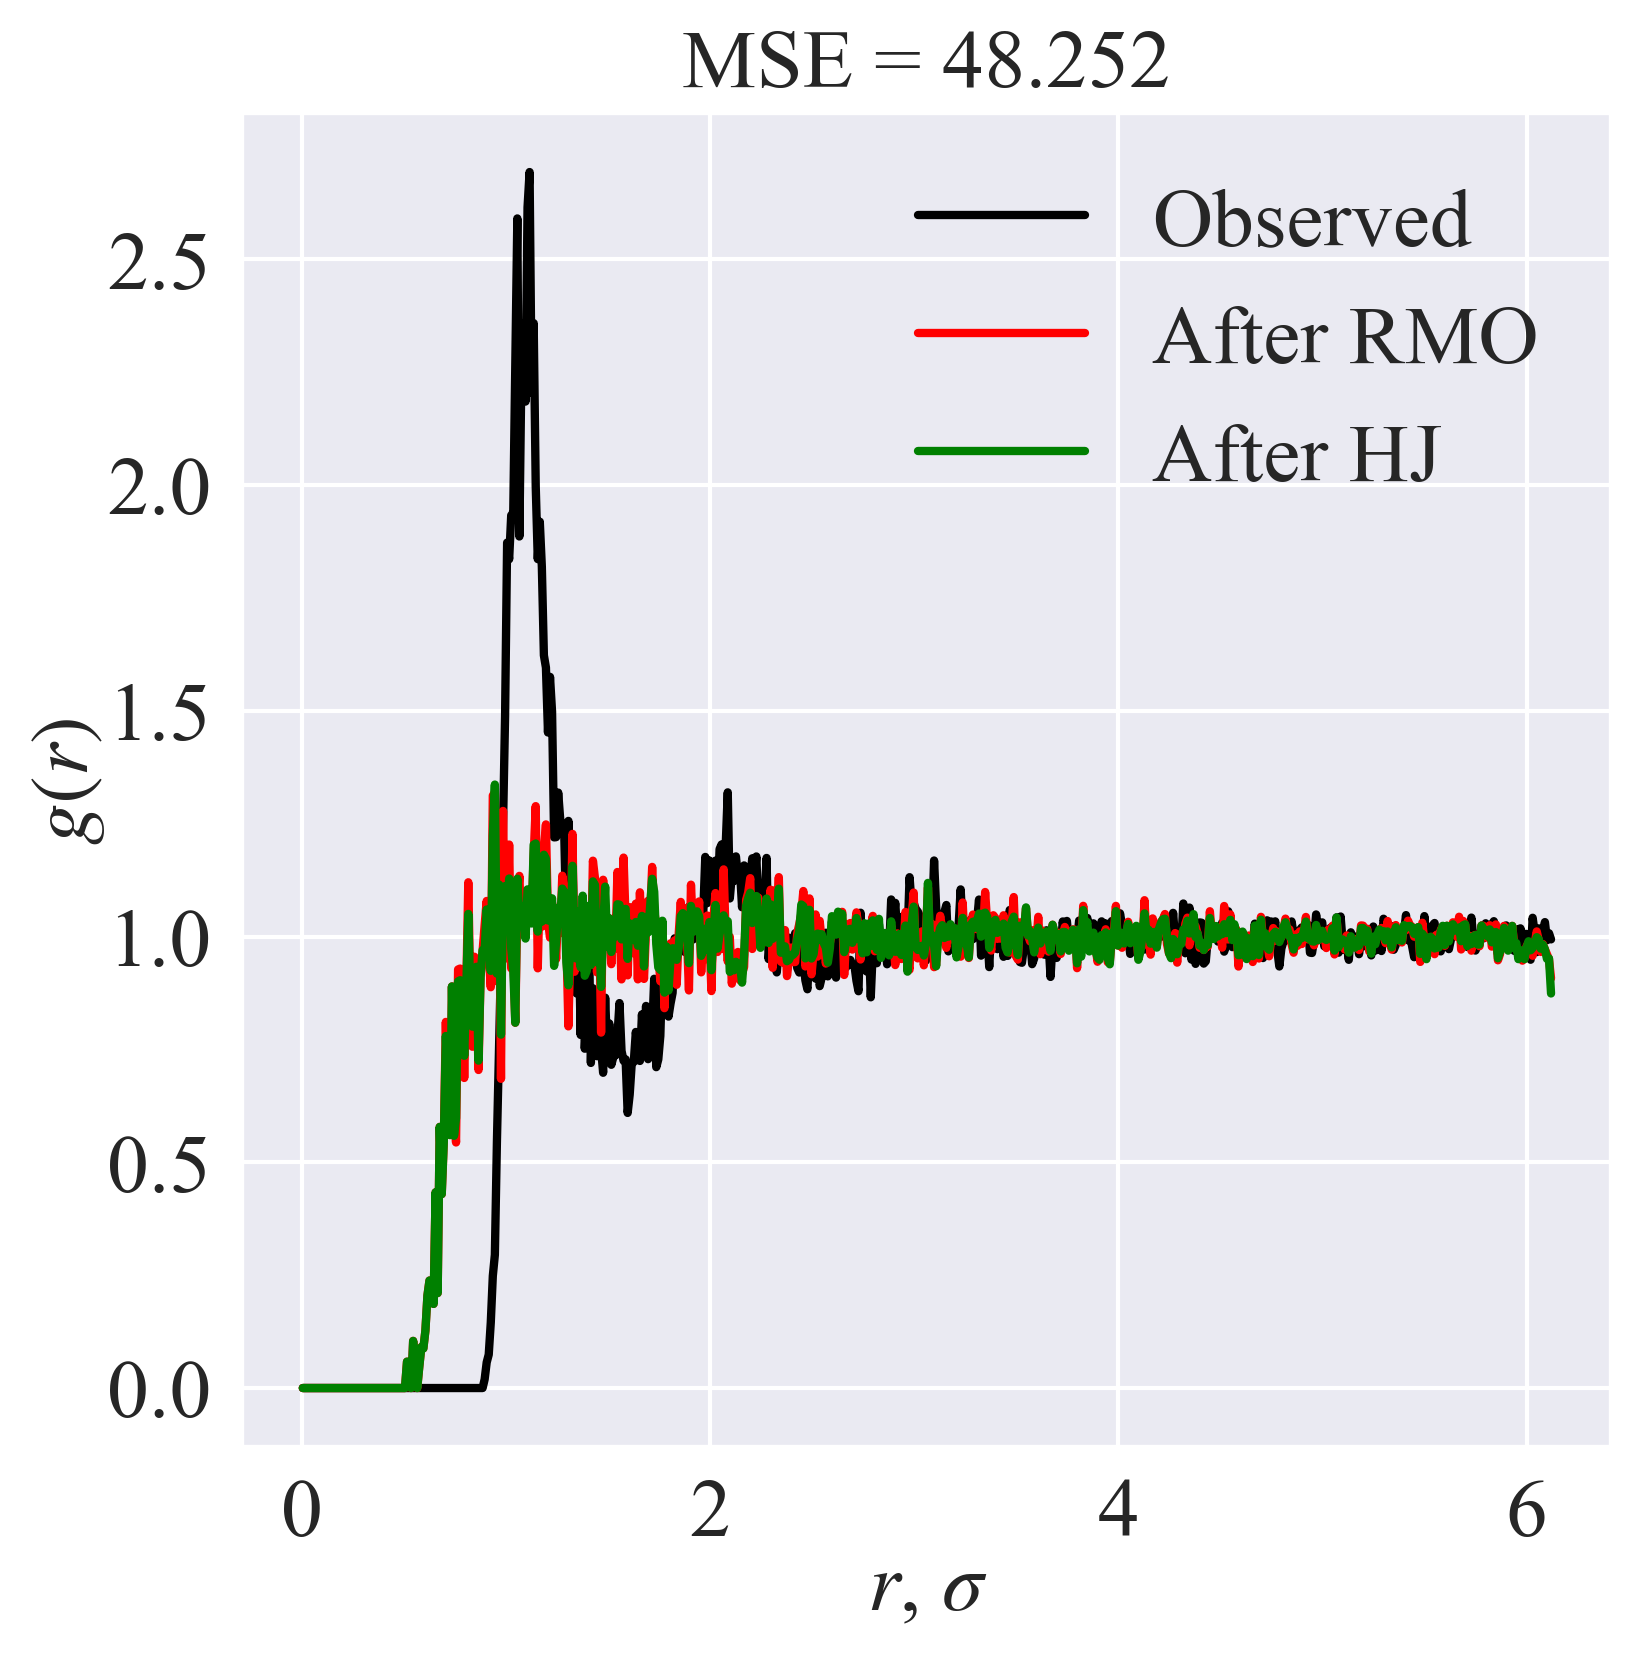

In [46]:
plotter = Plotter(
    path_to_plots=PATH_TO_PLOTS,
    labels=('radius', 'rdf'),
)
plotter.ax.plot(radii, obs_rdf, color='black', label='Observed')
plotter.ax.plot(radii, new_exp_rdf, color='red', label='After RMO')
plotter.ax.plot(radii, new_exp_rdf_hj, color='green', label='After HJ')
plotter.set_title(f'MSE = {mse(obs=obs_rdf, exp=new_exp_rdf_hj):.3f}')
plotter.get_legend()
plotter.save_plot('optimized_state_rmo_hj_random.png')
plt.show()

In [ ]:
cell_dimensions = np.ones(3) * 12.25
ovito_1 = OvitoProcessor(positions=some_positions, cell_dimensions=cell_dimensions)
ovito_2 = OvitoProcessor(positions=new_positions, cell_dimensions=cell_dimensions)

In [ ]:
indices_1 = get_unique_frame(ovito_1.get_voronoi_indices())
indices_2 = get_unique_frame(ovito_2.get_voronoi_indices())
for i in range(10):
    if i not in indices_1.columns:
        indices_1[i] = 0
    if i not in indices_2.columns:
        indices_2[i] = 0
merged_indices = indices_1.merge(
    right=indices_2, 
    on=list(range(10)), 
    how='outer',
).fillna(0).astype(int)
merged_indices['diff'] = merged_indices['counts_y'] - merged_indices['counts_x']
merged_indices

In [ ]:
volumes_1 = get_unique_frame(ovito_1.get_voronoi_volumes()).rename(columns={0: 'volume'})
volumes_2 = get_unique_frame(ovito_2.get_voronoi_volumes()).rename(columns={0: 'volume'})
merged_volumes = volumes_1.merge(
    right=volumes_2, 
    on='volume', 
    how='outer',
).fillna(0)
merged_volumes['diff'] = merged_volumes['counts_y'] - merged_volumes['counts_x']
merged_volumes

In [ ]:
coordinations_1 = get_unique_frame(ovito_1.get_voronoi_coordination()).rename(columns={0: 'coordination'})
coordinations_2 = get_unique_frame(ovito_2.get_voronoi_coordination()).rename(columns={0: 'coordination'})
merged_coordinations = coordinations_1.merge(
    right=coordinations_2, 
    on='coordination', 
    how='outer',
).fillna(0).astype(int)
merged_coordinations['diff'] = merged_coordinations['counts_y'] - merged_coordinations['counts_x']
merged_coordinations

In [ ]:
merged_indices = merged_indices[
    (merged_indices['counts_x'] > 1)
    & (merged_indices['counts_y'] > 1)
].reset_index(drop=True)
merged_indices

In [ ]:
merged_indices['diff'].describe()

In [ ]:
plt.bar(merged_coordinations['coordination'], merged_coordinations['counts_x'], alpha=0.5)
plt.bar(merged_coordinations['coordination'], merged_coordinations['counts_y'], alpha=0.5)
plt.show()

In [ ]:
hist, bins, _ = plt.hist(volumes_1['volume'], alpha=0.5)
plt.hist(volumes_2['volume'], alpha=0.5, bins=bins)
plt.show()

In [ ]:
radii, ovito_rdf_1, coordination_1 = ovito_1.get_rdf(is_coordination_returned=True)
radii, ovito_rdf_2, coordination_2 = ovito_2.get_rdf(is_coordination_returned=True)

In [ ]:
plt.plot(radii, ovito_rdf_1, label='1')
plt.plot(radii, ovito_rdf_2, label='2')
plt.legend()
plt.show()

In [ ]:
hist, bins, _ = plt.hist(coordination_1, alpha=0.5)
plt.hist(coordination_2, alpha=0.5, bins=bins)
plt.show()

In [ ]:
accuracies = np.array([1e-2, 1e-3, 1e-4, 1e-5])
times = np.array([291.500393, 547.916789, 981.426485, 1017.221477])
errors = np.array([0.1990364055106134, 0.13339311228418615, 0.0967833879874992, 0.09534158842519781])

plt.plot(accuracies, times / times.max(), label='Calculation time')
plt.plot(accuracies, errors / errors.max(), label='MSE after calculation')
plt.xscale('log')
plt.xlabel('Accuracy')
plt.legend()
plt.show()